<h1><center>Module 18: Lesson 5 Challenge: model comparison</center></h1>

## Challenge:

Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model.

_________________________________________________________________________________________________________________

##### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize



import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)

##### Grab data

In [45]:
blackfriday_df = pd.read_csv('BlackFriday.csv')

In [3]:
blackfriday_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [4]:
blackfriday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


* Dataframe is lightly too large and will require too much processing time. Lets cut this into a 1/4 to make it run faster.

In [79]:
blackfriday_df = blackfriday_df[:1000]

_________________________________________________________________________________________________________________

##### EDA

In [47]:
blackfriday_df.Gender.value_counts()

M    75528
F    24472
Name: Gender, dtype: int64

In [48]:
blackfriday_df.Age.value_counts()

26-35    39532
36-45    19943
18-25    18772
46-50     7965
51-55     7053
55+       3931
0-17      2804
Name: Age, dtype: int64

>I am going to select the age categories and the spend categories to try and predict gender. I expect these will be insufficient and I will need to add in other features as well. But first, lets plot these two features out and see if there is a distinction in Gender.

In [49]:
lb_make = LabelEncoder()
blackfriday_df["age_code"] = lb_make.fit_transform(blackfriday_df["Age"])
blackfriday_df[["Age", "age_code"]].head(11)

,Age,age_code
0,0-17,0
1,0-17,0
2,0-17,0
3,0-17,0
4,55+,6
5,26-35,2
6,46-50,4
7,46-50,4
8,46-50,4
9,26-35,2


In [50]:
lb_make = LabelEncoder()
blackfriday_df["gender_code"] = lb_make.fit_transform(blackfriday_df["Gender"])
blackfriday_df["city_code"] = lb_make.fit_transform(blackfriday_df["City_Category"])

In [51]:
blackfriday_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,age_code,gender_code,city_code
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,0,0,0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,0,0,0
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,0,0,0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,0,0,0
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969,6,1,2


_________________________________________________________________________________________________________________

Resource 1 - https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

Resource 2 - https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a

Resource 3 - https://medium.com/@george.drakos62/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-1-regrression-metrics-3606e25beae0

In [52]:
#find columns with missing values to drop...
missing_percent = (blackfriday_df.isnull().sum()/blackfriday_df.isnull().count()).sort_values(ascending=False)
missing_percent.head(40)

Product_Category_3            0.69502
Product_Category_2            0.31183
city_code                     0.00000
gender_code                   0.00000
age_code                      0.00000
Purchase                      0.00000
Product_Category_1            0.00000
Marital_Status                0.00000
Stay_In_Current_City_Years    0.00000
City_Category                 0.00000
Occupation                    0.00000
Age                           0.00000
Gender                        0.00000
Product_ID                    0.00000
User_ID                       0.00000
dtype: float64

In [53]:
# drop columns with missing values 

df = blackfriday_df.dropna(axis = 'columns')

In [54]:
df = df[['Purchase', 'age_code', 'gender_code', 'city_code', 'Product_Category_1', 'Marital_Status', 'Occupation']]

##### KNN Regression

In [55]:
# create x/y training subset

from sklearn.model_selection import train_test_split
train , test = train_test_split(df, test_size = 0.4)

x_train = train.drop('Purchase', axis=1)
y_train = train['Purchase']

x_test = test.drop('Purchase', axis=1)
y_test = test['Purchase']

In [56]:
# rescale 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

##  look at the rate of different K values

In [57]:
# look at the rate of different K values

#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 4222.306309829381
RMSE value for k=  2 is: 3803.115590846208
RMSE value for k=  3 is: 3623.106470313915
RMSE value for k=  4 is: 3557.1938502438265
RMSE value for k=  5 is: 3515.89780620811
RMSE value for k=  6 is: 3506.7401198792636
RMSE value for k=  7 is: 3515.7213848464053
RMSE value for k=  8 is: 3520.6493282489255
RMSE value for k=  9 is: 3528.1643283445696
RMSE value for k=  10 is: 3541.7776237800417
RMSE value for k=  11 is: 3559.210731511875
RMSE value for k=  12 is: 3566.1087440189244
RMSE value for k=  13 is: 3577.874322677151
RMSE value for k=  14 is: 3591.039920757262
RMSE value for k=  15 is: 3605.470434719735
RMSE value for k=  16 is: 3618.512239614958
RMSE value for k=  17 is: 3632.845263850328
RMSE value for k=  18 is: 3641.688831389949
RMSE value for k=  19 is: 3651.0802619895503
RMSE value for k=  20 is: 3659.7940752876552


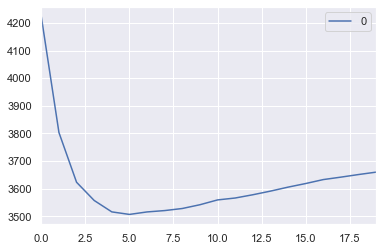

In [59]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

> Looking for the kink in our graph, it appears that we should take a k value of k=5. This is later confirmed by the cross validation to determine which k value is optimal.

In [60]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(x_train,y_train)
model.best_params_


{'n_neighbors': 6}

In [61]:
model.best_score_

0.47674642765415653

# Question... do we need to create a dataframe with all training data except the target column??

* using the towards datascience article code...

In [84]:
from sklearn.model_selection import train_test_split
#split dataset into train and test data
train , test = train_test_split(df, test_size = 0.4)

x_train = train.drop('Purchase', axis=1)
y_train = train['Purchase']

x_test = test.drop('Purchase', axis=1)
y_test = test['Purchase']

In [85]:
from sklearn import neighbors
# Create KNN classifier
knn = neighbors.KNeighborsRegressor(n_neighbors=10)

# Fit the classifier to the data
knn.fit(x_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

## Review Accuracy

In [87]:
print( 'The training accuracy score is {} '.format(model.score(x_train,y_train)))

The training accuracy score is -0.3155815615043305 


The test sets only have 1% accuracy 

In [88]:
print( 'The test accuracy score is {} '.format(model.score(x_test,y_test)))

The test accuracy score is -0.3155056237131426 


In [89]:
#predicting on the test set 
predict = model.predict(x_test)
predict

array([ 6381.33333333, 10148.83333333,  7638.        , ...,
        7358.16666667,  8951.16666667,  2566.83333333])

In [90]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(model, x_train, y_train, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


Unweighted Accuracy: 0.56 (+/- 0.01)


##### OLS Regression

Plot distribution of age

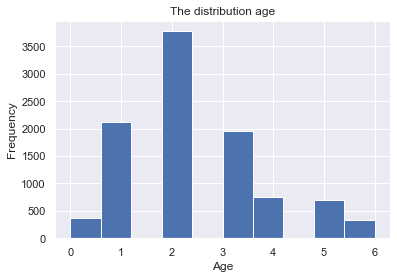

In [31]:
plt.hist(blackfriday_df.age_code)
plt.title("The distribution age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

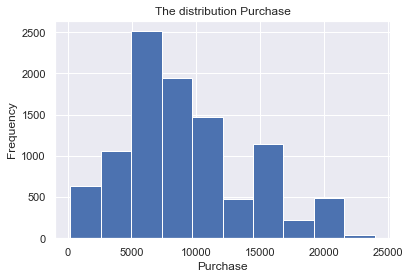

In [32]:
plt.hist(blackfriday_df.Purchase)
plt.title("The distribution Purchase")
plt.xlabel("Purchase")
plt.ylabel("Frequency")
plt.show()

I am not able to get a normal distribution for purchases. I am going to check for outliers and transform them. 

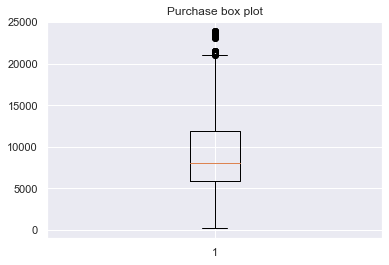

In [33]:

plt.boxplot(blackfriday_df.Purchase)
plt.title("Purchase box plot")
plt.show()

In [34]:
# We apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 
blackfriday_df['purch_tran']= winsorize(blackfriday_df.Purchase, (0, 0.10))


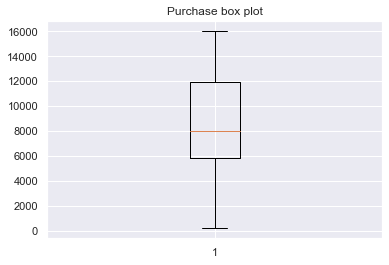

In [35]:

plt.boxplot(blackfriday_df.purch_tran)
plt.title("Purchase box plot")
plt.show()

In [36]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

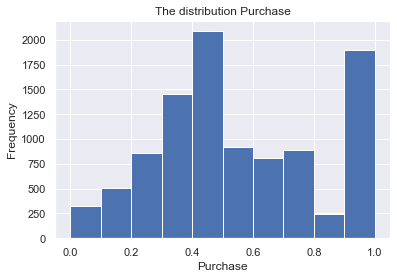

In [37]:
plt.hist(normalize(blackfriday_df.purch_tran))
plt.title("The distribution Purchase")
plt.xlabel("Purchase")
plt.ylabel("Frequency")
plt.show()

In [38]:
# Y is the target variable
Y = blackfriday_df['purch_tran']

# X is the feature set
X = blackfriday_df[['age_code', 'gender_code', 'city_code', 'Product_Category_1', 'Marital_Status', 'Occupation']]

In [39]:
from sklearn import linear_model
# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [  75.96802792  509.34067131  393.26227077 -415.44131838  -10.39174041
   -7.0891475 ]

Intercept: 
 10184.91819597767


In [40]:
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [41]:
results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             purch_tran   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     201.1
Date:                Sun, 02 Feb 2020   Prob (F-statistic):          1.25e-239
Time:                        11:01:48   Log-Likelihood:                -77789.
No. Observations:                8000   AIC:                         1.556e+05
Df Residuals:                    7993   BIC:                         1.556e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.024e+04    152.057     67.349      0.000    9942.840    1.05e+04
age_code              67.6740     35.981      1.881      0.060      -2.857     138.205
gender_code          476.2516    107.694      4.422      0.000     265.144     687.359
city_code            373.2851     57.665      6.473      0.000     260.247     486.323
Product_Category_1  -408.7607     12.321    -33.176      0.000    -432.913    -384.609
Marital_Status         5.1198     97.750      0.052      0.958    -186.496     196.736
Occupation            -5.0095      6.905     -0.725      0.468     -18.545       8.526
==============================================================================
Omnibus:                      246.619   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.716
Skew:                           0.443   Prob(JB):                     7.35e-59
Kurtosis:                       2.866   Cond. No.                         44.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
results_test = sm.OLS(y_test, X_test).fit()

results_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             purch_tran   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     58.70
Date:                Sun, 02 Feb 2020   Prob (F-statistic):           4.27e-67
Time:                        11:01:48   Log-Likelihood:                -19407.
No. Observations:                2000   AIC:                         3.883e+04
Df Residuals:                    1993   BIC:                         3.887e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               9976.0480    301.385     33.101      0.000    9384.985    1.06e+04
age_code             111.8835     71.296      1.569      0.117     -27.939     251.706
gender_code          647.9053    211.038      3.070      0.002     234.028    1061.783
city_code            475.7259    113.449      4.193      0.000     253.235     698.217
Product_Category_1  -445.4618     25.225    -17.659      0.000    -494.932    -395.991
Marital_Status       -81.1490    195.158     -0.416      0.678    -463.885     301.587
Occupation           -16.3213     13.694     -1.192      0.233     -43.178      10.535
==============================================================================
Omnibus:                       58.864   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.688
Skew:                           0.437   Prob(JB):                     1.48e-14
Kurtosis:                       2.984   Cond. No.                         44.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""